<a href="https://colab.research.google.com/github/RCortez25/Scientific-Machine-Learning/blob/main/Differential_equations/Heat_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heat equation

In [ ]:
# Import libraries
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets

# Exact solution for reference
u_exact = (x,t) -> exp.(-t) * cos.(x)

Since one has the exact solution for this PDE, having it will help for comparing with the solver.

*   `->` defines an anonymous function, like a lambda function in Python. In this case `(x,t)` will be mapped to the formula

$$u(x,t)=e^{-t}\cos(x)$$

*   `.` is for boradcasting. If `t` or `x` are not single scalar values, then the operation is performed element-wise



In [ ]:
# Parameters, variables, and derivatives
@parameters t x
@variables u(..)
Dt = Differential(t)
Dxx = Differentia(x)^2

*   Define tha independent variables to be `t` and `x`
*   Define the dependent variable to be `u`. In this case, `u(..)` just means `u` will be a function of the parameters
*   Define the operator $\partial_t$
*   Define the operator $\partial_{xx}$




In [ ]:
# Define the 1D PDE
pde = Dt(u(t, x)) ~ Dxx(u(t, x))

# Boundary conditions
bcs = [
    u(0, x) ~ cos(x),
    u(t, 0) ~ exp(-t),
    u(t, 1) ~ exp(-t) * cos(1)
]

# Space and time domains
domains = [
    t ∈ Interval(0.0, 1.0),
    x ∈ Interval(0.0, 1.0)
]

* `Dt(u(t, x)) ~ Dxx(u(t, x))` defines the PDE, that is

$$
\begin{align*}
\partial_tu(t,x)&=\partial_{xx}u(t,x)
\end{align*}
$$

In Julia `~` means `=`.

* One defines the boundary conditions, in this case

$$
\begin{align*}
u(0, x) &= \cos(x) \\
u(t, 0) &= e^{-t} \\
u(t, 1) &= e^{-t} \cos(1)
\end{align*}
$$

* Moreover, we define the domains for the independent variables

$$
\begin{align*}
t &\in[0,1] \\
x &\in[0,1]
\end{align*}
$$

In [ ]:
# Setting up the PDE system
@named oPDESystem = PDESystem(pde, bcs, domains, [t, x], [u(t, x)])

One defines the system of PDEs, which include, in this order

*   The PDE istself
*   Boundary conditions
*   Domains of the independent variables
*   The independent variables
*   The dependent variable $u(t,x)$

and store it in the variable `oPDESystem`.






In [ ]:
# Method of Lines discretization
# Step size
dx = 0.1
# Second order approximation for finite differences
order = 2
# Discretize variable x with spacing dx, leave t continuous
discretization = MOLFiniteDifference([x => dx], t)

One sets up the **Method of lines** for solving the problem. We choose


*   A step-size of $dx=0.1$. Since $x\in[0,1]$ one has 11 points of size $0.1$
*   `order=2` indicates the accuracy of the finite difference scheme to be used, that is, a second-porder scheme for apporximating derivatives. For instance

$$\partial_{xx}u\approx\frac{u(x+dx)-2u(x)+u(x-dx)}{(dx)^2}$$

*   Create a `MOLFiniteDifference` object that discretizes the variable `x` with spacing `dx`. The variable `t` is left as continuous. This is so, because the solver will solve the solution in time. This object is like a "recipe object", saying that if one ever passes a PDE system to it, it will discretize $x$ and leave $t$ as continuous.



In [ ]:
# Convert the PDE problem into an ODE problem
problem = discretize(oPDESystem, discretization)

This creates the problem to be solved. We use the method of lines, that is, the `discretization` object and pass it to the `discretize` function along with the system of PDEs to be solved, namely, `oPDESystem`. The `discretize` function applies the discretization rule to the PDE.

Now we have a set of ODEs, one at each point of the spatial grid for $x$. With this, one only solves the problem *in time* only.

That is

$$\partial_tu=\partial_{xx}u$$

was transformed into

$$\frac{d}{dt}U_i(t)=\frac{U_{i+1}(t)-2U_i(t)+U_{i-1}(t)}{(dx)^2}$$

for each interior point $i$.

Using the `discretize` function, the "recipe" called `discretization` is applied to the `oPDESystem`. So the `discretize` function is appying the recipe to the system.

---
**The `discretize` function**

With $dx=0.1$ one has

$$x_0=0,x_1=0.1,x_2=0.2,\ldots,x_{10}=1$$

The interior points are

$$u(t,x_1),\ldots,u(t,x_9)$$

These interior points are the points that one evolves in time, like a movie. One can imagine them like a line, with the $x$-value fixed, the value of $u$ at each $t$ changes in time.

One then defines

$$U(t)=\begin{bmatrix}u(t,0.1) \\ \vdots \\u(t,0.9)\end{bmatrix}$$

Now, for

$$\partial_tu=\partial_{xx}u$$

one has that the LHS can be tackled with the methods one knows, but the RHS is harder., so one approximates

$$\partial_{xx}u(x_i)\approx\frac{u(t,x_{i+1})-2u(t,x_i)+u(t,x_{i-1})}{(dx)^2}$$

Then, the system is one of ODEs of the form

$$D_tU(t)=AU(t)+b(t)$$

where $b(t)$ comes from the boundary conditions. This is the system that `discretize` gives one.

---

In [ ]:
# Solve the problem
solution = solve(problem, Tsit5(), saveat=0.2)

Solve the discretized problem

*   `Tsit5()`: 5th-order, adaptive non-stiff ODE solver (can try `Rosenbrock23()` or `TRBDF2()` if there are stiffness problems
*   `saveat=0.2`: Record the solution every 0.2 units, that is, at `t=0.0, t=0.2, t=0.4`
*   `reltol=1e-3` and `abstol=1e-6` are the default tolerances.




In [ ]:
# Plot the results and compare with the true solution
# Obtain the grids for plotting and the values of the function
# at those points
x_grid = solution[x]
t_grid = solution[t]
solution_values = solution[u(t, x)]

In these lines of code one retrieves the grids and the values of the function at those points in order to plot them.

The `solution` object stores:


*   Time points where the solver saved
*   Arrays of dependent variables $u(t,x)$ at those points
*   Interpolation rules for evaluating at times it didn't save

Then, the object can be queried to obtain:


*   `solution[t]` time grid
*   `solution[x]` spatial grid
*   `solution[u(t,x)]` the actual values of the function $u(t,x)$ on that grid

Once again, the function can be evaluated at points not in the grid, for example, at $u(0.1,7)$ thanks to the interpolation rules saved by the `solution` object.

In [ ]:
# Plots
plt = plot()

for i in eachindex(t_grid):
    plot!(x_grid, solution_values[i, :], label="Numerical, t=$(t_grid[i])")
    scatter!(x_grid, u_exact(x_grid, t_grid[i]), label="Exact, t=$(t_grid[i])")
end

plt

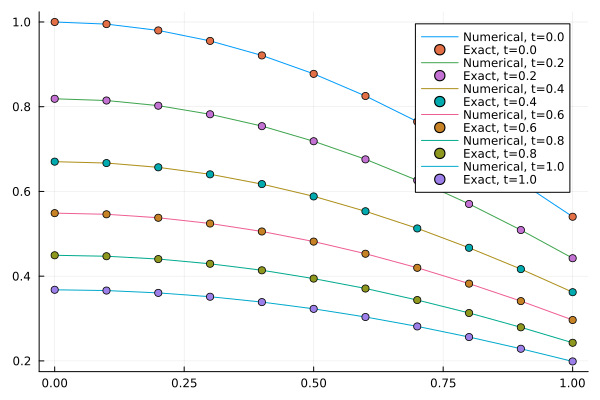